# Flujos de Potencia Óptimos (ACOPF)

**Contribución de**: Uriel Sandoval

Esta notebook contiene la implementación de un flujos de potencia óptimos en el lenguaje Julia.

Para ejecutar los comandos los siguientes paquetes de Julia son necesarios:


* [JuMP](https://jump.dev/)  
* [Ipopt](https://github.com/coin-or/Ipopt): Solver para problemas no-lineales.
* [PowerSystems](https://nrel-siip.github.io/PowerSystems.jl/stable/): Paquete para leer archivos de MatPower y PSS/E.

Los paquetes pueden ser instalados de la siguiente forma:

```Julia
import Pkg;
Pkg.add(["JuMP", "Ipopt", "PowerSystems"])
```

Los archivos de prueba fueron obtenidos del repositorio de [Power Grid Lib](https://github.com/power-grid-lib/pglib-opf), el cual es mantenido activamente por el [IEEE PES Task Force](https://arxiv.org/abs/1908.02788).

En la literatura se pueden encontrar diversas formulaciones del ACOPF, sin embargo para propósitos educativos y tratando ser lo más claro posible, la formulación aquí mostrada es igual a la implementada en [Matpower](https://matpower.org/).

Adicionalmente, el lector puede verificar sus resultados con los reportados en [The Power Grid Library for Benchmarking AC Optimal Power Flow Algorithms](https://arxiv.org/abs/1908.02788).


Empezamos importando los paquetes necesarios

In [10]:
using JuMP, Ipopt;
using PowerSystems;

A continuación usamos la librería PowerSystems para leer el archivo *pglib_opf_case14_ieee.m*

In [11]:
# Código tomado de  https://stackoverflow.com/questions/48195775/how-to-pretty-print-nested-dicts-in-julia

function pretty_print(d::Dict, pre=1)
    for (k,v) in d
        if typeof(v) <: Dict
            s = "$(repr(k)) => "
            println(join(fill(" ", pre)) * s)
            pretty_print(v, pre+1+length(s))
        else
            println(join(fill(" ", pre)) * "$(repr(k)) => $(repr(v))")
        end
    end
    nothing
end

pretty_print (generic function with 2 methods)

Datos en formato Matpower del sistema de 5 nodos:

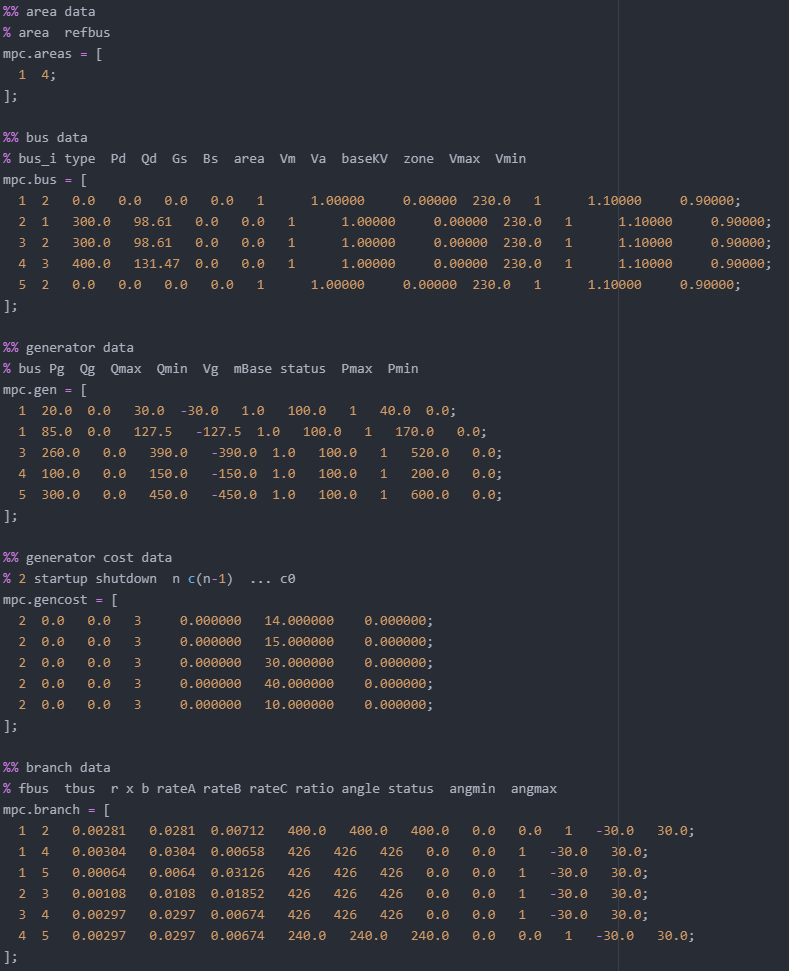


In [12]:
# Leemos los datos utilizando PowerSystems
dat = PowerSystems.PowerModelsData("data/pglib_opf_case5_pjm.m").data;

# Los siguientes únicamente son aliases
branches = dat["branch"];
buses = dat["bus"];
gens = dat["gen"];
loads = dat["load"];
shunts = dat["shunt"];

┌ Info: extending matpower format with data: areas 1x3
└ @ PowerSystems C:\Users\UFSANDOVAL\.julia\packages\PowerSystems\hE7SB\src\parsers\pm_io\matpower.jl:332
┌ Info: removing 1 cost terms from generator 4: [4000.0, 0.0]
└ @ PowerSystems C:\Users\UFSANDOVAL\.julia\packages\PowerSystems\hE7SB\src\parsers\pm_io\data.jl:1867
┌ Info: removing 1 cost terms from generator 1: [1400.0, 0.0]
└ @ PowerSystems C:\Users\UFSANDOVAL\.julia\packages\PowerSystems\hE7SB\src\parsers\pm_io\data.jl:1867
┌ Info: removing 1 cost terms from generator 5: [1000.0, 0.0]
└ @ PowerSystems C:\Users\UFSANDOVAL\.julia\packages\PowerSystems\hE7SB\src\parsers\pm_io\data.jl:1867
┌ Info: removing 1 cost terms from generator 2: [1500.0, 0.0]
└ @ PowerSystems C:\Users\UFSANDOVAL\.julia\packages\PowerSystems\hE7SB\src\parsers\pm_io\data.jl:1867
┌ Info: removing 1 cost terms from generator 3: [3000.0, 0.0]
└ @ PowerSystems C:\Users\UFSANDOVAL\.julia\packages\PowerSystems\hE7SB\src\parsers\pm_io\data.jl:1867


In [13]:
pretty_print(dat)

 "bus" => 
           "4" => 
                   "zone" => 1
                   "bus_i" => 4
                   "bus_type" => 3
                   "vmax" => 1.1
                   "source_id" => Any["bus", 4]
                   "area" => 1
                   "vmin" => 0.9
                   "index" => 4
                   "va" => 0.0
                   "vm" => 1.0
                   "base_kv" => 230.0
           "1" => 
                   "zone" => 1
                   "bus_i" => 1
                   "bus_type" => 2
                   "vmax" => 1.1
                   "source_id" => Any["bus", 1]
                   "area" => 1
                   "vmin" => 0.9
                   "index" => 1
                   "va" => 0.0
                   "vm" => 1.0
                   "base_kv" => 230.0
           "5" => 
                   "zone" => 1
                   "bus_i" => 5
                   "bus_type" => 2
                   "vmax" => 1.1
                   "source_id" => Any["bus", 5]
   

                     "source_id" => Any["areas", 1]
                     "col_1" => 1
                     "col_2" => 4
                     "index" => 1
 "shunt" => 
 "load" => 
            "1" => 
                    "source_id" => Any["bus", 2]
                    "load_bus" => 2
                    "status" => 1
                    "qd" => 0.9861
                    "pd" => 3.0
                    "index" => 1
            "2" => 
                    "source_id" => Any["bus", 3]
                    "load_bus" => 3
                    "status" => 1
                    "qd" => 0.9861
                    "pd" => 3.0
                    "index" => 2
            "3" => 
                    "source_id" => Any["bus", 4]
                    "load_bus" => 4
                    "status" => 1
                    "qd" => 1.3147
                    "pd" => 4.0
                    "index" => 3


In [14]:
pretty_print(buses)

 "4" => 
         "zone" => 1
         "bus_i" => 4
         "bus_type" => 3
         "vmax" => 1.1
         "source_id" => Any["bus", 4]
         "area" => 1
         "vmin" => 0.9
         "index" => 4
         "va" => 0.0
         "vm" => 1.0
         "base_kv" => 230.0
 "1" => 
         "zone" => 1
         "bus_i" => 1
         "bus_type" => 2
         "vmax" => 1.1
         "source_id" => Any["bus", 1]
         "area" => 1
         "vmin" => 0.9
         "index" => 1
         "va" => 0.0
         "vm" => 1.0
         "base_kv" => 230.0
 "5" => 
         "zone" => 1
         "bus_i" => 5
         "bus_type" => 2
         "vmax" => 1.1
         "source_id" => Any["bus", 5]
         "area" => 1
         "vmin" => 0.9
         "index" => 5
         "va" => 0.0
         "vm" => 1.0
         "base_kv" => 230.0
 "2" => 
         "zone" => 1
         "bus_i" => 2
         "bus_type" => 1
         "vmax" => 1.1
         "source_id" => Any["bus", 2]
         "area" => 1
         "vmin" => 

In [15]:
# Creamos los conjuntos a ser utilizados en los indices de JuMP
B = keys(buses);
L = keys(branches);
G = keys(gens);
C = keys(loads);
S = keys(shunts);

@show(B)
@show(L)

B = ["4", "1", "5", "2", "3"]
L = ["4", "1", "5", "2", "6", "3"]


Base.KeySet for a Dict{String,Any} with 6 entries. Keys:
  "4"
  "1"
  "5"
  "2"
  "6"
  "3"

In [16]:
##  Creamos un mapeo  bus -> elemento, para los dispositivos de una terminal

# Mapeo: bus -> [cargas]
load_map = Dict((i, String[]) for i in B);
for (key, load) in loads
    push!(load_map[string(load["load_bus"])], key)
end

# Mapeo: bus -> [gens]
gen_map = Dict((i, String[]) for i in keys(buses));
for (key, load) in gens
    push!(gen_map[string(load["gen_bus"])], key)
end

# Mapeo: bus -> [shunts]
shunt_map = Dict((i, String[]) for i in keys(buses));
for (key, load) in shunts
    push!(shunt_map[string(load["shunt_bus"])], key)
end

In [17]:
@show(load_map)

load_map = Dict("4" => ["3"],"1" => [],"5" => [],"2" => ["1"],"3" => ["2"])


Dict{String,Array{String,1}} with 5 entries:
  "4" => ["3"]
  "1" => String[]
  "5" => String[]
  "2" => ["1"]
  "3" => ["2"]

## Modelado de la red eléctrica

Esta sección presenta el modelado de la red eléctrica utilizando JuMP. Se consideran los elementos más importantes de un sistemas de potencia:

* Nodos.
* Ramas (lineas de transmisión y transformadores).
* Cargas y equipos de compensación shunt.
* Generadores




In [18]:
# Creamos el modelo de JuMP y asignamos el solver a utilizar (Ipopt)
mod = Model(Ipopt.Optimizer);

### Nodo

Los nodos son elementos topológicos y son la unidad mínima de modelado en una red eléctrica. Los elementos *shunt* (cargas, reactores, generadores, etc) están conectados a un bus, mientras que los elementos serie están conectados a dos o más buses al mismo tiempo.


Considerando un sistema balanceado y una representación de secuencia positiva, cada nodo tiene varias valores complejos asociados: un voltaje fasorial, inyecciones de potencia y corriente complejas. El voltaje puede ser representado en coordenadas poalres como: $\bar v = v e^{j\delta}$. Siguiendo esta representación cada nodo tiene un dos variables reales asociadas: magnitud de voltaje $v$ y ángulo de voltaje $\delta$.

Estas dos variables deben de ser consideradas para cada bus $k \in \mathcal{B}$. Adicionalmente, la magnitud de voltaje de cada bus deberá permanecer dentro de límites:

$$
v_k^{\min} \leq v_k \leq v_k^{\max} \quad \forall k \in \mathcal{B}
$$,

Por último, para el nodo de referencia angular se deberá considerar la siguiente restricción:


$$
\delta_{\text{swing}} = \delta^{\text{ref}}
$$.

In [19]:
@variable(mod, buses[k]["vmin"] <= v[k in B] <= buses[k]["vmax"], start = 1.0);

@variable(mod, δ[k in B], start = 0.0);


for (k, bus_data) in buses
    
    # Limites de voltaje 
    #set_lower_bound(v[k], bus_data["vmin"]);
    #set_upper_bound(v[k], bus_data["vmax"]);

    # Referencia angular para el nodo "slack"
    if (bus_data["bus_type"] == 3)
        set_lower_bound(δ[k], bus_data["va"]);
        set_upper_bound(δ[k], bus_data["va"]);
    end
end

Notar que en Julia podemos definir cualquier caracter Unicode. Para la lista completa consultar la [documentación de Julia](https://docs.julialang.org/en/v1/manual/unicode-input/).

In [20]:
v

1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, ["4", "1", "5", "2", "3"]
And data, a 5-element Array{VariableRef,1}:
 v[4]
 v[1]
 v[5]
 v[2]
 v[3]

In [21]:
UpperBoundRef(v["4"])

v[4] <= 1.1

In [22]:
LowerBoundRef(v["1"])

v[1] >= 0.9

### Modelo generalizado de ramas

El siguiente modelo de secuencia positiva considera una impedancia serie $\bar z_{s} = r_{s} + jx_{s} = \bar y_{s}^{-1}$ y una susceptacia total $b^{sh} = 2b^{sh}_k= 2b^{sh}_m$. El transformador, puede ser modelado con una relación de transformación $\tau$ y un angulo de defase $\theta$. Este tap complejo consideramos que está en el nodo de envío de la rama, tal cual se muestra en la siguiente figura:


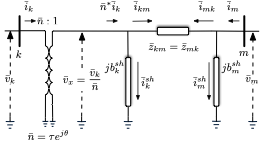


A partir de este circuito equivalente, podemos calcular la potencia compleja inyectada a cada nodo:

$$
      \begin{align}
        \bar s_k &= \bar v_k \bar i_k ^*\\
        \bar s_m &= \bar v_m \bar i_m ^*\,.
      \end{align}
$$


Utilizando la ley de  Kirchhoff, la inyección de corriente $\bar i_k$ es escrita como:

$$
      \begin{equation}
        \bar  n^* i_k = \bar i_{km} + \bar i_{k}^{sh}\,,
      \end{equation}
$$


lo cual también puede ser expresado en términos de voltajes nodales:
$$
      \begin{align}
          \bar n ^* \bar i_k &= \bar y_{s}\left(\bar v_x - \bar v_m\right) +
                     jb_k^{sh}\bar v_x \\
                   &= \frac{\bar v_k}{\bar n} \left(\bar y_{s} + jb_k^{sh}\right) - \bar v_m \bar y_{s} \\
        \bar i_k &= \frac{\bar v_k}{\tau^2} \left(\bar y_{s} + jb_k^{sh}\right) - \frac{\bar  v_m}{\bar n^*}\bar y_{s} \,,\label{eq: ik}
      \end{align}
$$

Aplicando un procedimiento similar al nodo receptor $m$ obtenemos lo siguiente:


$$
      \begin{align}
        \bar i_m &= \bar v_m \left(\bar y_{s} + jb_m^{sh}\right) - \frac{\bar v_k}{\bar n} \bar y_s \,. \label{eq: im}
      \end{align}
$$


Ahora, las corrientes $\bar i_k$ y $\bar i_m$ pueden ser expresadas de forma matricial:

$$
      \begin{align}
        \begin{bmatrix}
        \bar i_k\\
        \bar i_m
        \end{bmatrix} &=
        \begin{bmatrix}
        \frac{1}{\tau ^2}\left(\bar y_s + jb_k^{sh}\right) &  - \frac{1}{\bar n^*}\bar y_s \\
        -\frac{1}{\bar n}\bar y_s                  & \bar y_s + jb_m^{sh}
        \end{bmatrix}
        \begin{bmatrix}
        \bar v_k \\
        \bar v_m
        \end{bmatrix}\\
        &=\begin{bmatrix}
          \bar Y_{kk}  & \bar Y_{km}\\
          \bar Y_{mk}  & \bar Y_{mm}
          \end{bmatrix}
          \begin{bmatrix}
          \bar v_k \\
          v_m
          \end{bmatrix}\,.
      \end{align}
$$

A partir de esta representación matricial, el flujo inyectado en los nodos $k$ y $m$ pueden ser calculados para cada elemento $l$:
$$
      \begin{align}
        p_{l,k} &= v_k^2 G_{kk} + v_kv_m\left(G_{km} \cos{\delta_{km}} + B_{km} \sin{\delta_{km}}\right) \label{eq: p_k}\\
        q_{l,k} &=-v_k^2 B_{kk} + v_kv_m\left(G_{km} \sin{\delta_{km}} - B_{km} \cos{\delta_{km}}\right) \label{eq: q_k}\\
        p_{l,m} &= v_m^2 G_{mm} + v_m v_k\left(G_{mk} \cos{\delta_{mk}} + B_{mk} \sin{\delta_{mk}}\right) \label{eq: p_m}\\
        q_{l,m} &=-v_m^2 B_{mm} + v_m v_k\left(G_{mk} \sin{\delta_{mk}} - B_{mk} \cos{\delta_{mk}}\right) \label{eq: q_m}\,,
      \end{align}
$$

donde

$$
      \begin{align}
        \delta_{km} &= \delta_k-\delta_m = -\delta_{mk}\\
        \bar Y_{km} &= G_{km} + jB_{km}\,. \\
      \end{align}
$$

Entonces, para calcular el flujo de potencia en cualquier elemento de la red de transmisión es necesario obtener o calcular los parámetros $\bar Y_{kk}$, $\bar Y_{km}$, $\bar Y_{mk}$, y $\bar Y_{mm}$.

Adicionalmente, dentro de la formulación de flujos óptimos podemos limitar la potencia apartene en cualquier elemento de la red de transmisón:



$$
p_{l,k}^2 + q_{l,k}^2 \leq {s_l^{\max}}^2 \\
p_{l,m}^2 + q_{l,m}^2 \leq {s_l^{\max}}^2
$$



In [27]:
# Los siguientes diccionarios mapean bus->{Pkm, Qkm, Pmk, Qmk} 
Pinj_f_bra = Dict((k, []) for k in B);
Pinj_t_bra = Dict((k, []) for k in B);
Qinj_f_bra = Dict((k, []) for k in B);
Qinj_t_bra = Dict((k, []) for k in B);


for brn in values(branches)
    
    # Nodos k y m
    k = string(brn["f_bus"]);
    m = string(brn["t_bus"]);
    
    # Calculamos la admitancia serie entre los nodos k y m
    Ys = 1.0 /(brn["br_r"] + im * brn["br_x"]);
    Bc = brn["b_fr"];
    Gc = brn["g_fr"];
    # Calculamos el tap complejo (magnitud de tap y ángulo de desfase)
    cTap = brn["tap"] * exp(deg2rad(brn["shift"])  * im  )
    
    # Admitancia vista desde el nodo m
    Ymm =  Ys + Gc + im*Bc;
    # Admitancia vista desde el nodo k
    Ykk = Ymm / brn["tap"]^2;
    # Admitancia entre los nodos k y m
    Ykm =  - Ys /conj(cTap);
    # Admitancia entre los nodos m y k
    Ymk = - Ys /cTap
    brn["Gkk"] = real(Ykk); brn["Bkk"] = imag(Ykk);
    brn["Gkm"] = real(Ykm); brn["Bkm"] = imag(Ykm);
    brn["Gmm"] = real(Ymm); brn["Bmm"] = imag(Ymm);
    brn["Gmk"] = real(Ymk); brn["Bmk"] = imag(Ymk);
        
    if (brn["br_status"] == 0)
        @info("La rama %s entre los nodos %d y %d está inactiva", key, brn["f_bus"], brn["t_bus"])
        continue
    end
    
    # Expresion no-lineal del flujo de potencia activa y reactiva entre el nodo k y m
    Pkm = @NLexpression(mod, v[k]^2 * brn["Gkk"] +
                             v[k] * v[m] * (brn["Gkm"] *  cos(δ[k] - δ[m]) +
                                            brn["Bkm"] *  sin(δ[k] - δ[m])));
    Qkm = @NLexpression(mod, -v[k]^2 * brn["Bkk"] +
                             v[k] * v[m] * (brn["Gkm"] *  sin(δ[k] - δ[m]) -
                                            brn["Bkm"] *  cos(δ[k] - δ[m])));

    # Expresion no-lineal del flujo de potencia activa y reactiva entre el nodo m y k
    Pmk = @NLexpression(mod, v[m]^2 * brn["Gmm"] +
                             v[m] * v[k] * (brn["Gmk"] *  cos(δ[m] - δ[k]) +
                                            brn["Bmk"] *  sin(δ[m] - δ[k])));
    Qmk = @NLexpression(mod, -v[m]^2 * brn["Bmm"] +
                             v[m] * v[k] * (brn["Gmk"] *  sin(δ[m] - δ[k]) -
                                            brn["Bmk"] *  cos(δ[m] - δ[k])));

    # Incluímos la expresión no-lineal en cada una de las listas de inyecciones a nivel nodo
    push!(Pinj_f_bra[k], Pkm);
    push!(Qinj_f_bra[k], Qkm);
    push!(Pinj_t_bra[m], Pmk);
    push!(Qinj_t_bra[m], Qmk);

    # En caso que tengamos un límite térmico que cuidar. Agregamos la restricción
    if (brn["rate_a"] > 0)
        # Restricción de potencia aparente: Skm <= Smax
        @NLconstraint(mod, Pkm^2 + Qkm^2 <= brn["rate_a"]^2);
        # Restricción de potencia aparnte: Smk <= Smax
        @NLconstraint(mod, Pmk^2 + Qmk^2 <= brn["rate_a"]^2);
    end
    
    
end

In [28]:
Pinj_f_bra

Dict{String,Array{Any,1}} with 5 entries:
  "4" => Any["Reference to nonlinear expression #41"]
  "1" => Any["Reference to nonlinear expression #29", "Reference to nonlinear e…
  "5" => Any[]
  "2" => Any["Reference to nonlinear expression #25"]
  "3" => Any["Reference to nonlinear expression #33"]

### Generator

Podemos denotar al conjunto de generadores con el símbolo $\mathcal{G}$. La variables $p_{G_i}$ y $q_{G_i}$ son entonces las potencias activa y reactiva generadas por el generador $i \in \mathcal{G}$, respectivamente. Cada una de estas variables deberá estar dentro de límites:


$$
p_{G_i}^{\min} \leq p_{G_i} \leq p_{G_i}^{\max} \quad \forall i \in \mathcal{G} \\
q_{G_i}^{\min} \leq q_{G_i} \leq q_{G_i}^{\max} \quad \forall i \in \mathcal{G}
$$.

In [29]:
@variable(mod, gens[i]["pmin"] <= Pg[i in G] <= gens[i]["pmax"]);
@variable(mod, gens[i]["qmin"] <= Qg[i in G] <= gens[i]["qmax"]);

LoadError: An object of name Pg is already attached to this model. If this is intended, consider using the anonymous construction syntax, e.g., x = @variable(model, [1:N], ...) where the name of the object does not appear inside the macro.

In [26]:
for i in G
    println(i)
    println(UpperBoundRef(Pg[i]))
    println(LowerBoundRef(Pg[i]))
end

4
Pg[4] <= 2.0
Pg[4] >= 0.0
1
Pg[1] <= 0.4
Pg[1] >= 0.0
5
Pg[5] <= 6.0
Pg[5] >= 0.0
2
Pg[2] <= 1.7
Pg[2] >= 0.0
3
Pg[3] <= 5.2
Pg[3] >= 0.0


### Ecuaciones de balance de potencia nodal


Siguiendo la ley de Kirchhoff, sabemos que la suma de corrientes (en este caso potencias) en un nodo debe ser cero:


$$
\sum_{i \in \mathcal{G}} p_{G_i} - \sum_{i \in \mathcal{C}} p_{L_i} - 
\sum_{s \in \mathcal{S}} v_i^2 g_{s} - \sum_{(k,m) \in \mathcal{E}} p_{km}  -
\sum_{(m,k) \in \mathcal{E}} p_{mk} = 0 \quad \forall k \in \mathcal{B} \\
\sum_{i \in \mathcal{G}} q_{G_i} - \sum_{i \in \mathcal{C}} q_{L_i} + 
\sum_{s \in \mathcal{S}} v_i^2 b_{s} - \sum_{(k,m) \in \mathcal{E}} q_{km}  -
\sum_{(m,k) \in \mathcal{E}} q_{mk} = 0 \quad \forall k \in \mathcal{B}
$$

In [18]:
# Pg - Pd - Psh - Pkm == 0
@NLconstraint(mod, dP[k in B], sum(Pg[i] for i in gen_map[k]) -
                               sum(loads[load]["pd"] for load in load_map[k]) -
                               sum(shunts[shunt]["gs"] * v[k]^2 for shunt in shunt_map[k]) -
                               sum(Pkm for Pkm in Pinj_f_bra[k]) -
                               sum(Pmk for Pmk in Pinj_t_bra[k]) ==0 );
# Qg - Qd + Qsh - Qkm == 0
@NLconstraint(mod, dQ[k in B], sum(Qg[i] for i in gen_map[k]) -
                               sum(loads[load]["qd"] for load in load_map[k]) +
                               sum(shunts[shunt]["bs"] * v[k]^2 for shunt in shunt_map[k]) -
                               sum(Qkm for Qkm in Qinj_f_bra[k]) -
                               sum(Qmk for Qmk in Qinj_t_bra[k]) ==0 );


### Función objetivo

La función objetivo del problema de flujos óptimos es minimizar el costo de producción total:

$$
\min \sum_{i \in \mathcal{G}} f_{C_i}\left( P_{G_i} \right) = \sum_{i \in \mathcal{G}}\left( c_i P_{G_i}^2 + b_i P_{G_i} + c_i \right)
$$


In [19]:
@objective(mod, Min, 
    sum(sum(gen["cost"][j] * Pg[i] ^(gen["ncost"] - j) for j in 1:gen["ncost"]) for (i, gen) in gens));

In [20]:
mod

A JuMP Model
Minimization problem with:
Variables: 20
Objective function type: GenericQuadExpr{Float64,VariableRef}
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 16 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 16 constraints
Nonlinear: 22 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Ipopt
Names registered in the model: Pg, Qg, dP, dQ, v, δ

## Resolver el problema de optimización

In [30]:
optimize!(mod)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       84
Number of nonzeros in Lagrangian Hessian.............:      192

Total number of variables............................:       19
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       15
                     variables with only upper bounds:        0
Total number of equa

El resultado anterior es exactamente el mismo que el publicado en [PoderModels](https://lanl-ansi.github.io/PowerModels.jl/stable/experiment-results/):


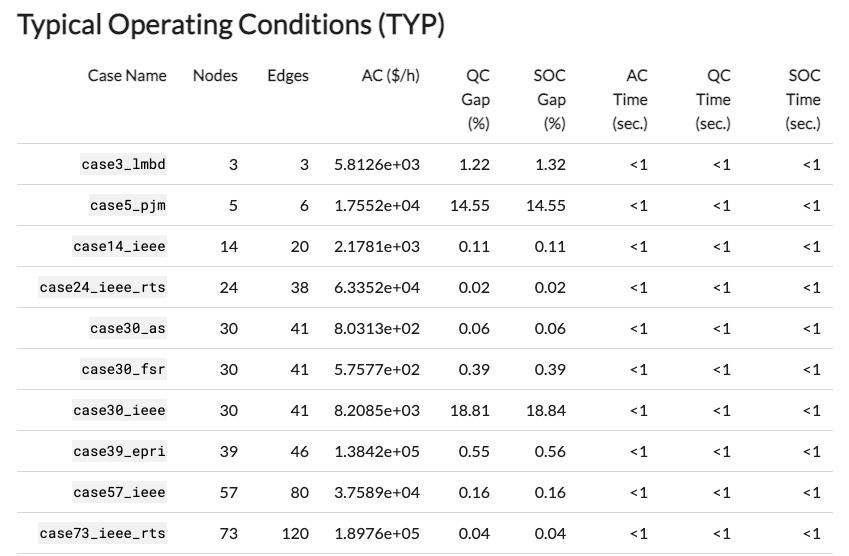

Podemos *encapsular* todas las funciones antes mencionadas en una sóla función que resuelva un OPF unicamente dándole el nombre del archivo:

In [31]:
include("scripts/acopf.jl")

run_ACOPF (generic function with 1 method)

In [32]:
@time dat, mod = run_ACOPF("data/pglib_opf_case5_pjm.m");

┌ Info: extending matpower format with data: areas 1x3
└ @ PowerSystems C:\Users\UFSANDOVAL\.julia\packages\PowerSystems\hE7SB\src\parsers\pm_io\matpower.jl:332
┌ Info: removing 1 cost terms from generator 4: [4000.0, 0.0]
└ @ PowerSystems C:\Users\UFSANDOVAL\.julia\packages\PowerSystems\hE7SB\src\parsers\pm_io\data.jl:1867
┌ Info: removing 1 cost terms from generator 1: [1400.0, 0.0]
└ @ PowerSystems C:\Users\UFSANDOVAL\.julia\packages\PowerSystems\hE7SB\src\parsers\pm_io\data.jl:1867
┌ Info: removing 1 cost terms from generator 5: [1000.0, 0.0]
└ @ PowerSystems C:\Users\UFSANDOVAL\.julia\packages\PowerSystems\hE7SB\src\parsers\pm_io\data.jl:1867
┌ Info: removing 1 cost terms from generator 2: [1500.0, 0.0]
└ @ PowerSystems C:\Users\UFSANDOVAL\.julia\packages\PowerSystems\hE7SB\src\parsers\pm_io\data.jl:1867
┌ Info: removing 1 cost terms from generator 3: [3000.0, 0.0]
└ @ PowerSystems C:\Users\UFSANDOVAL\.julia\packages\PowerSystems\hE7SB\src\parsers\pm_io\data.jl:1867


This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       70
Number of nonzeros in inequality constraint Jacobian.:       42
Number of nonzeros in Lagrangian Hessian.............:      254

Total number of variables............................:       19
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       15
                     variables with only upper bounds:        0
Total number of equality constraints.................:       10
Total number of inequality constraints...............:       12
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       12

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [33]:
@time dat, mod = run_ACOPF("data/pglib_opf_case5_pjm.m");

┌ Info: extending matpower format with data: areas 1x3
└ @ PowerSystems C:\Users\UFSANDOVAL\.julia\packages\PowerSystems\hE7SB\src\parsers\pm_io\matpower.jl:332
┌ Info: removing 1 cost terms from generator 4: [4000.0, 0.0]
└ @ PowerSystems C:\Users\UFSANDOVAL\.julia\packages\PowerSystems\hE7SB\src\parsers\pm_io\data.jl:1867
┌ Info: removing 1 cost terms from generator 1: [1400.0, 0.0]
└ @ PowerSystems C:\Users\UFSANDOVAL\.julia\packages\PowerSystems\hE7SB\src\parsers\pm_io\data.jl:1867
┌ Info: removing 1 cost terms from generator 5: [1000.0, 0.0]
└ @ PowerSystems C:\Users\UFSANDOVAL\.julia\packages\PowerSystems\hE7SB\src\parsers\pm_io\data.jl:1867
┌ Info: removing 1 cost terms from generator 2: [1500.0, 0.0]
└ @ PowerSystems C:\Users\UFSANDOVAL\.julia\packages\PowerSystems\hE7SB\src\parsers\pm_io\data.jl:1867


This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       70
Number of nonzeros in inequality constraint Jacobian.:       42
Number of nonzeros in Lagrangian Hessian.............:      254

Total number of variables............................:       19
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       15
                     variables with only upper bounds:        0
Total number of equality constraints.................:       10
Total number of inequality constraints...............:       12
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       12

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

┌ Info: removing 1 cost terms from generator 3: [3000.0, 0.0]
└ @ PowerSystems C:\Users\UFSANDOVAL\.julia\packages\PowerSystems\hE7SB\src\parsers\pm_io\data.jl:1867


In [35]:
@time run_ACOPF("data/pglib_opf_case2383wp_k.m");

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    33125
Number of nonzeros in inequality constraint Jacobian.:    23152
Number of nonzeros in Lagrangian Hessian.............:   152862

Total number of variables............................:     5288
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2906
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4766
Total number of inequality constraints...............:     5792
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     5792

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

┌ Info: reversing the orientation of branch 661 (346, 344) to be consistent with other parallel branches
└ @ PowerSystems C:\Users\UFSANDOVAL\.julia\packages\PowerSystems\hE7SB\src\parsers\pm_io\data.jl:1218
